# Random Forest Analysis:
The goal of this analysis is to predict vaccine response (`vaccine_response`) using features such as `d_geo_mean`, `visit_age`, `gender`, and `race`. Then we moved onto predicting the vaccine response (`vaccine_response`) using immune cell types captured in the `name_formatted` column.
We used a Random Forst classifier since it has the great abiliy to handle high-dimensional data and to a certain extenct can balance bias-variance trade-offs. Regarding the latter prediction task, since the data is highly variable and quite complex, this migth be a good classifier to use. This is also why this has not been used using the other (previous) algorithms. 

## Step 1 - Importing Necessary Libraries

In [8]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek

## Step 2 - Importing Necessary files


In [9]:
""" We need to use the fluprint data instead of the aggregaget data as this contains the name_formatted column """

path_to_fluprint = r"C:\Users\danie\OneDrive\Documents\Applied Data science\FluPRINT_database\FluPRINT_filtered_data\Fluprint.csv"
fluprint_data = pd.read_csv(path_to_fluprint)

## Step 3 - Random Forest Classifier

### Objective:
The goal of this analysis is to predict vaccine response (`vaccine_response`) using features such as `d_geo_mean`, `visit_age`, `gender`, and `race`. 

**Hyperparameter Tuning**:
   - A grid of hyperparameters is defined to optimize the Random Forest model:
     - `n_estimators`: Number of trees in the forest.
     - `max_depth`: Maximum depth of each tree.
     - `min_samples_split`: Minimum samples required to split a node.
     - `min_samples_leaf`: Minimum samples required at a leaf node.
   - **RandomizedSearchCV** is used for hyperparameter tuning with 5-fold cross-validation, optimizing for the **F1 macro score**.

**Model Training and Evaluation**:
- The best model from hyperparameter tuning is trained on the training set.
- Performance is evaluated on the test set using metrics such as accuracy, precision, recall, and F1-score.

In [4]:
X = pd.get_dummies(fluprint_data[["d_geo_mean", "visit_age", "gender", "race"]], columns=["gender", "race"], drop_first=True)
y = fluprint_data["vaccine_response"]

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Perform cross-validation with hyperparameter tuning
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, cv=5, scoring='f1_macro', n_iter=10, n_jobs=-1)
random_search.fit(X, y)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation F1 Score: {random_search.best_score_:.3f}")

# Train and evaluate on test set with best parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Best Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5}
Best Cross-Validation F1 Score: 0.724
Best Model Performance:
Accuracy: 0.87
              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90     15650
         1.0       0.71      0.98      0.82      6757

    accuracy                           0.87     22407
   macro avg       0.85      0.90      0.86     22407
weighted avg       0.90      0.87      0.88     22407



### Key Observations:
1. **Overall Performance**:
   - The model achieves a high accuracy of **87%** (the best one so far -out of all the models), indicating that it correctly classifies most samples.
   - The macro average F1 score of **0.86** suggests balanced performance across both classes, accounting for precision and recall.

2. **Class-Specific Performance**:
   - **Class 0 (Low Responders)**:
     - Very high precision (**0.99**) indicates that almost all predicted low responders are true low responders.
     - Recall (**0.82**) is slightly lower, meaning some true low responders are misclassified as high responders.
   - **Class 1 (High Responders)**:
     - Precision (**0.71**) is lower, meaning there are some false positives where low responders are misclassified as high responders.
     - Recall (**0.98**) is very high, indicating that nearly all true high responders are correctly identified.

### Let's just check that the csv file has no NaN values.

Since the machine learning algorithm cannot inheritely deal with NAN values, we need to also check that the data contains no NANs. If the data were to contain this, we would have had to handle this missing data (like in previous notebooks) either by removing some or using an Inputter. Since there are no gaps here, we can be sure that data integrity did not affect the previous results.

In [4]:
# Check for missing values in features
missing_values = X.isnull().sum()
print("Missing values in X:\n", missing_values)

# Check for missing values in target
print("Missing values in y:", y.isnull().sum())

Missing values in X:
 d_geo_mean                        0
visit_age                         0
gender_Male                       0
race_Black or African American    0
race_Caucasian                    0
race_Hispanic/Latino              0
race_Other                        0
dtype: int64
Missing values in y: 0


---

## Step 4 - Implementation of SMOTE with Random Forest

Very similar to the previous step but we apply SMOTE (Synthetic Minority Oversampling Technique) in order to try and overcome the class imbalance issue.
While the model performs well overall (high accuracy and macro F1 score), the precision for Class 1 (High Responders) is relatively low (0.71), which suggests that the model struggles with false positives for this class.

Using SMOTE can help balance the dataset by synthetically generating new samples for the minority class (Class 1). This might improve the model's ability to distinguish between high and low responders, potentially improving precision for Class 1 without sacrificing recall.

In [10]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE only on the training set
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize Random Forest with class balancing
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_grid,
                                   cv=5,
                                   scoring='f1_macro',
                                   n_iter=10,
                                   n_jobs=-1)
random_search.fit(X_train_smote, y_train_smote)

# Print best parameters and cross-validation score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation F1 Score: {random_search.best_score_:.3f}")

# Train best model on SMOTE-balanced training data
best_model = random_search.best_estimator_
best_model.fit(X_train_smote, y_train_smote)

# Evaluate model on original test data
y_pred = best_model.predict(X_test)
print("Best Model Performance After SMOTE:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': None}
Best Cross-Validation F1 Score: 0.988
Best Model Performance After SMOTE:
Accuracy: 0.98
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     15650
         1.0       0.95      1.00      0.97      6757

    accuracy                           0.98     22407
   macro avg       0.97      0.99      0.98     22407
weighted avg       0.98      0.98      0.98     22407



### Key Observations:

1. **Overall Performance**:
   - The model achieves an extremely high accuracy of **98%**, indicating that it correctly classifies nearly all samples in the test set.
   - The macro average F1 score of **0.98** demonstrates balanced performance across both classes, accounting for both precision and recall.

2. **Class-Specific Performance**:
   - **Class 0 (Low Responders)**:
     - Precision is perfect (**1.00**), meaning all predicted low responders are true low responders.
     - Recall is very high (**0.98**), indicating that only a small fraction of true low responders are misclassified as high responders.
   - **Class 1 (High Responders)**:
     - Precision is strong (**0.95**), meaning most predicted high responders are true high responders.
     - Recall is perfect (**1.00**), meaning all true high responders are correctly identified.

3. **Impact of SMOTE**:
   - SMOTE helped balance the training data by generating synthetic samples for the minority class (high responders).
   - This improved the model's ability to recognize high responders, as evidenced by the perfect recall for Class 1 and an overall increase in precision and F1 scores.
   ---

### PCA Visualisation of SMOTE-Applied Data:
The goal is to assess whether SMOTE effectively separates the classes or if there is significant overlap, which could indicate potential issues with the synthetic data and the model's ability to generalise.

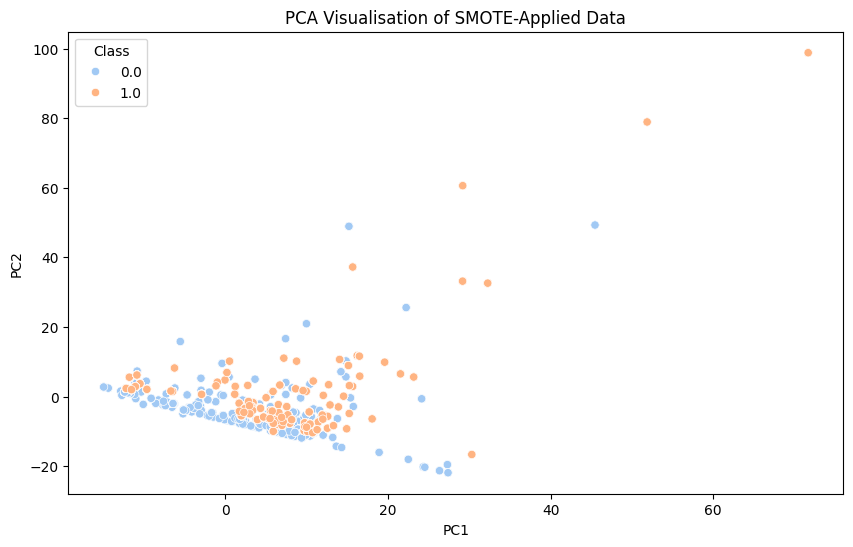

In [11]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Perform PCA for visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_smote)

# Create a DataFrame for visualisation
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y_train_smote

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Class', palette='pastel')
plt.title("PCA Visualisation of SMOTE-Applied Data")
plt.show()

### Interpretation: 

**Significant Overlap**: The substantial overlap between the two classes suggests that the original features do not strongly discriminate between low and high responders, even after applying SMOTE. The model might not generalise well to new, unseen data because it is overfitting to the synthetic samples or learning patterns that are not robust.

---

### PCA Plot After SMOTETomek

SMOTETomek tries to solve this by combining SMOTE with the Tomek Links method. A Tomek Link is a pair of very close instances from different classes. After SMOTE generates the synthetic samples, Tomek Links identifies pairs of instances from different classes that are close to each other and removes the majority class instance from each pair. 

Therefore, the goal of SMOTETomek is not only to address class imbalance but also to reduce noise and improve class separation, and in theory ahould lead to better separation between the classes

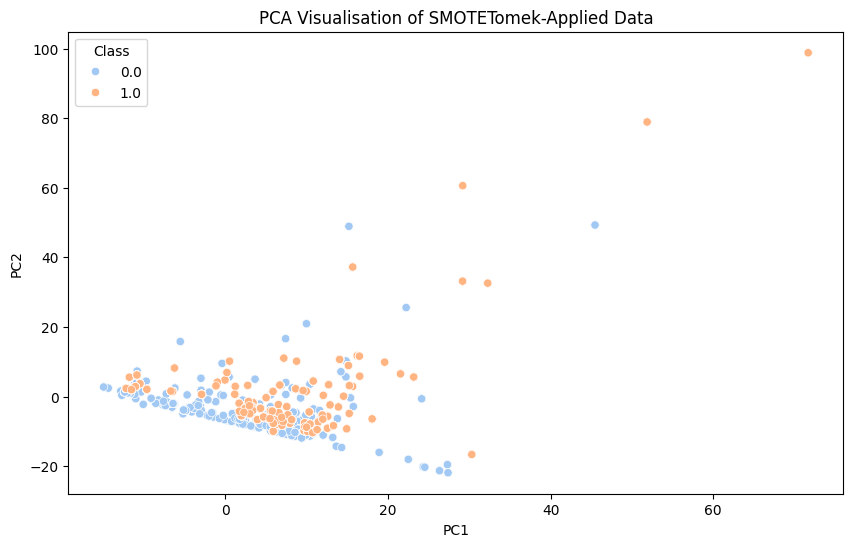

In [15]:
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Perform PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y_train_resampled

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Class', palette='pastel')
plt.title("PCA Visualisation of SMOTETomek-Applied Data")
plt.show()

### Interpretation: 

**Significant Overlap Remains**: Despite using SMOTETomek (which combines oversampling and undersampling to remove noisy samples), there is still substantial overlap between the classes. It suggests that the original data contains significant overlap, and this overlap persists even after applying SMOTETomek.

**SMOTETomek Effects**: SMOTETomek has likely reduced some of the noise or outliers that were present in the original data.

**PCA Limitations**: PCA might not be the best dimensionality reduction technique for this data. It focuses on maximising variance, which doesn't necessarily maximise class separation.

### Key Implications:

1. **Misleading Metrics**:
   - High accuracy scores obtained during training and testing might be overoptimistic due to the model learning patterns specific to the synthetic data rather than generalisable characteristics.

2. **Limited Generalisation**:
   - The model might not generalise well to new, unseen data because it is overfitting to the synthetic samples or learning patterns that are not robust.

3. **No Clear Separation**:
   - Overlap of classes implies the initial features and methods applied lack robustness.

### Conclusion:
Despite various optimisation steps, the data's inherent lack of clear class separation remains a limiting factor. 

---

## Step 6 - Using the `name_formatted` Column:

The `name_formatted` column contains information about the immune cell types present at the site of vaccination post-vaccination. The goal is to use this information to predict vaccine response (`vaccine_response`) more effectively.

### Why Not Use Simple Models?
- **High Dimensionality**: The `name_formatted` column, when one-hot encoded, results in multiple features representing different immune cell types. This high-dimensional data makes simpler models like polynomial or logistic regression unsuitable.
- **Complex Interactions**: Vaccine response is likely influenced by complex interactions between immune cell types and cytokines. Simple models cannot capture these interactions effectively.

In [8]:
X = pd.get_dummies(fluprint_data[["name_formatted", "data"]], columns=["name_formatted"], drop_first=True)
y = fluprint_data["vaccine_response"]

### Data Integrity Check: Ensuring No Empty Cells

Before proceeding with our Random Forest algorithm, it's important to verify the integrity of our dataset. We performed a (bit of a different than the eariler one in the notebook) check for missing values, including both NaN (Not a Number) entries and empty strings. Since there are a lot of rows, listing them like in the previous example would not work and instead we must take a different approach (as shown below).

The absence of missing values in our dataset indicates:

1. **Data Completeness**: All cells contain valid data, ensuring we're working with a complete dataset.
2. **No Preprocessing Needed**: We can proceed with our Random Forest algorithm without the need for imputation or handling of missing values.
3. **Reliability**: The completeness of our data enhances the reliability of our subsequent analysis and model predictions.

In [ ]:
 # Check if there are any NaN values in the DataFrame
if X.isnull().values.any():
    print("Missing values detected!")
    # Count missing values per column
    missing_values = X.isnull().sum()
    print("Missing values in each column:\n", missing_values[missing_values > 0])
else:
    print("No missing values in the features!")

# Check if there are any NaN values in the target variable
if y.isnull().values.any():
    print("Missing values detected in the target variable!")
    print(f"Number of missing values in y: {y.isnull().sum()}")
else:
    print("No missing values in the target variable!")

No missing values in the features!
No missing values in the target variable!


In [ ]:
# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Perform cross-validation with hyperparameter tuning
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, cv=5, scoring='f1_macro', n_iter=10, n_jobs=-1)
random_search.fit(X, y)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation F1 Score: {random_search.best_score_:.3f}")

# Train and evaluate on test set with best parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test) 

Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': None}
Best Cross-Validation F1 Score: 0.504
Best Model Performance:
Accuracy: 0.56


'              precision    recall  f1-score   support\n\n         0.0       0.71      0.61      0.66     15650\n         1.0       0.32      0.43      0.37      6757\n\n    accuracy                           0.56     22407\n   macro avg       0.52      0.52      0.51     22407\nweighted avg       0.60      0.56      0.57     22407\n'

In [12]:
print("Best Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Best Model Performance:
Accuracy: 0.56
              precision    recall  f1-score   support

         0.0       0.71      0.61      0.66     15650
         1.0       0.32      0.43      0.37      6757

    accuracy                           0.56     22407
   macro avg       0.52      0.52      0.51     22407
weighted avg       0.60      0.56      0.57     22407



1. **Low Overall Performance**:
   - The model struggles to generalize effectively, as shown by the modest cross-validation F1 score (0.504) and test accuracy (56%).
   - The imbalance between classes (15,650 Class 0 vs. 6,757 Class 1) contributes to poor performance on the minority class (High Responders).

2. **Class-Specific Challenges**:
   - **Class 1 (High Responders)**:
     - Very low precision (0.32) indicates many false positives (low responders incorrectly classified as high responders).
     - Moderate recall (0.43) suggests the model misses over half of true high responders.
   - **Class 0 (Low Responders)**:
     - Better but still suboptimal performance (F1 = 0.66), indicating room for improvement.

3. **Hyperparameter Insights**:
   - The model uses deep trees (`max_depth=None`) with minimal splitting constraints (`min_samples_split=2`), which risks overfitting to noise in the training data.
   - Despite tuning, the hyperparameters fail to balance performance across classes.

In [13]:
# Split the data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original training set shape:", X_train.shape, y_train.shape)
print("Resampled training set shape:", X_train_resampled.shape, y_train_resampled.shape)

C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
 

Original training set shape: (89625, 3283) (89625,)
Resampled training set shape: (125104, 3283) (125104,)


In [14]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}

rf_model = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   cv=5, scoring='f1_macro', n_iter=20, n_jobs=-1, random_state=42)
random_search.fit(X_train_resampled, y_train_resampled)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation F1 Score: {random_search.best_score_:.3f}")

# Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
print("Best Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': 'balanced'}
Best Cross-Validation F1 Score: 0.669
Best Model Performance:
Accuracy: 0.59
              precision    recall  f1-score   support

         0.0       0.71      0.70      0.70     15639
         1.0       0.32      0.33      0.32      6768

    accuracy                           0.59     22407
   macro avg       0.51      0.51      0.51     22407
weighted avg       0.59      0.59      0.59     22407

